# Question 2: Peak times for crime occurrances

This notebook aims to answer the second question of the project.

In each year: What are the peak times for crime occurences? Does it change according to season? Is there a concentration of crime around a specific period of the year?

In [1]:
# Dependencies

from pathlib import Path 
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Read in data
# df = pd.read_csv(Path('resources', 'mci_no_duplicates_2018_20_22.csv'))

# read all data instead
df = pd.read_csv(Path('resources', 'mci_no_duplicates_2014_and_over.csv'))

# Keep only the relevant columns, rename them and drop na
df = (df[['OCC_DATE', 'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_DOY', 'OCC_DOW', 'OCC_HOUR', 'MCI_CATEGORY', 'OFFENCE']]
    .rename(
        columns={
            'OCC_DATE': 'Date',
            'OCC_YEAR': 'Year',
            'OCC_MONTH': 'Month',
            'OCC_DAY': 'Day of the Month',
            'OCC_DOY': 'Day of the Year',
            'OCC_DOW': 'Day of the Week',
            'OCC_HOUR': 'Hour',
            'MCI_CATEGORY': 'Category',
            'OFFENCE': 'Offence',
        }
    )
    # .dropna(thresh=7)
)


# Make year a string 
df['Year'] = (df['Year']
    .astype('string')
    .str.replace('.0', '',regex=False)
)


# Make month an ordered categorical variable
df['Month'] = (df['Month']
    .astype(
        CategoricalDtype(
            categories=[
                'January',
                'February',
                'March',
                'April',
                'May',
                'June',
                'July',
                'August',
                'September',
                'October',
                'November',
                'December'
            ],
            ordered=True))
)

# Make day of the week an ordered categorical variable
df['Day of the Week'] = (df['Day of the Week']
    .str.strip()
    .astype(
        CategoricalDtype(
            categories=[
                'Monday',
                'Tuesday',
                'Wednesday',
                'Thursday',
                'Friday',
                'Saturday',
                'Sunday'
            ],
            ordered=True)
    )
)

df.head()

,Date,Year,Month,Day of the Month,Day of the Year,Day of the Week,Hour,Category,Offence
0,2014-01-01,2014,January,1.0,1.0,Wednesday,3.0,Break and Enter,B&E
1,2014-01-01,2014,January,1.0,1.0,Wednesday,4.0,Assault,Assault
2,2014-01-01,2014,January,1.0,1.0,Wednesday,4.0,Theft Over,Theft Over
3,2014-01-01,2014,January,1.0,1.0,Wednesday,4.0,Assault,Assault
4,2014-01-01,2014,January,1.0,1.0,Wednesday,2.0,Assault,Assault Bodily Harm


In [3]:
# check for NAs
# df.loc[df['Hour'].isna()]



## By year

In [4]:
# general counts by year
df_by_year = (df
    .groupby('Year', as_index=False)
    .size()
    .rename(columns={'size': 'Number of events'})
)
df_by_year

,Year,Number of events
0,2014,30202
1,2015,30641
2,2016,31157
3,2017,32790
4,2018,34772
5,2019,37114
6,2020,32456
7,2021,32114
8,2022,37226


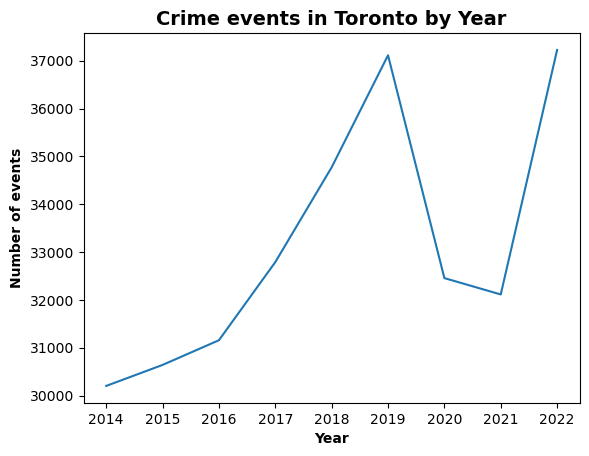

In [5]:
fig, ax = plt.subplots()

ax.plot(
    df_by_year['Year'],
    df_by_year['Number of events']
)

plt.xlabel('Year', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto by Year',
    fontdict={'weight': 700, 'size': 14}
)

plt.show()

In [6]:
# count by category and year
year_category_count = (df
    .groupby(['Year', 'Category'], as_index=False)
    .size()
    .rename(columns={'size': 'Number of events'})
)
year_category_count.head(10)

,Year,Category,Number of events
0,2014,Assault,15294
1,2014,Auto Theft,3485
2,2014,Break and Enter,7216
3,2014,Robbery,3193
4,2014,Theft Over,1014
5,2015,Assault,16547
6,2015,Auto Theft,3090
7,2015,Break and Enter,6934
8,2015,Robbery,3028
9,2015,Theft Over,1042


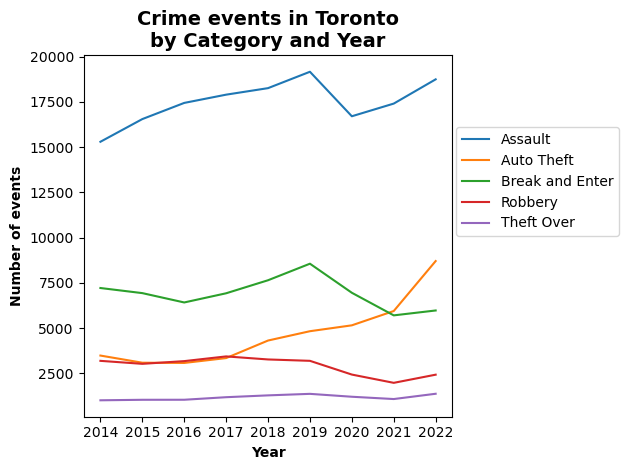

In [7]:
# Visualize

# List ofcategories
mci_cats = list(year_category_count['Category'].unique())

fig, ax = plt.subplots()

for mci_cat in mci_cats:
    this_data = year_category_count.loc[year_category_count['Category'] == mci_cat]
    # add this category to plot
    ax.plot(
        this_data['Year'],
        this_data['Number of events'],
        label=mci_cat,
        clip_on = False
    )

plt.xlabel('Year', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto\nby Category and Year',
    fontdict={'weight': 700, 'size': 14}
    )
plt.legend(loc=(1.01, 0.5))
# year_category_count.plot(
#     kind='bar',
#     stacked=False
# )
plt.tight_layout()
plt.show()

In [8]:
# year_offence_count = (df
#     .groupby(['Year', 'Category', 'Offence'], as_index=False)
#     .size()
#     .fillna(0)
#     .rename(columns={'size': 'Number of events'})
# )

# year_offence_count

In [9]:
# # get number of offences per category
# cat_sizes = list(
#     year_offence_count[['Category', 'Offence']]
#         .drop_duplicates()
#         .groupby('Category')
#         .size()
# )
# cat_sizes

In [10]:
# # Visualize
# fig, axs = plt.subplots(
#     nrows=len(mci_cats),
#     ncols=1,
#     # sharex=True,
#     figsize=(20, 40),
#     # layout = 'constrained',
#     gridspec_kw={'height_ratios': cat_sizes}
# )

# # fig.subplots_adjust(hspace=0)

# # counters
# min_count = 50
# i = 0

# # one category for each subplot
# for mci_cat in mci_cats:
#     ax = axs[i]
#     this_data = (year_offence_count
#         .loc[
#             (year_offence_count['Category'] == mci_cat) &
#             (year_offence_count['Number of events']>min_count)
#         ]
#         .drop(columns=['Category'])
#         .pivot(
#             columns='Year',
#             values='Number of events',
#             index='Offence'
#         )
#         # .fillna(0)
#         .dropna()
#     )
#     this_data.columns.name = None
#     offences = list(this_data.index.unique())
#     x = np.arange(len(offences))  # the label locations
#     width = 0.25  # the width of the bars
#     multiplier = 0
#     for attribute, measurement in dict(this_data).items():
#         offset = width * multiplier
#         rects = ax .barh(x + offset, measurement, width, label=attribute)
#         ax.bar_label(rects, padding=3)
#         multiplier += 1

#     # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.invert_yaxis()
#     ax.set_title(
#         'MCI Category: ' + mci_cat,
#         fontdict={'weight': 700, 'size': 14}
#     )
#     ax.set_xlabel('Number of events', fontdict={'weight': 700})
#     ax.set_ylabel('Offence', fontdict={'weight': 700})
#     ax.set_yticks(x + width, offences)
#     ax.grid(True, axis='x')
#     ax.legend(loc='upper right')

#     i += 1

# plt.show()


## By month

In [11]:
df_by_month = (df
    .groupby('Month', as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

df_by_month

,Month,Number of events
0,January,23583
1,February,21289
2,March,23789
3,April,23274
4,May,25505
5,June,25565
6,July,26463
7,August,26249
8,September,25876
9,October,26729


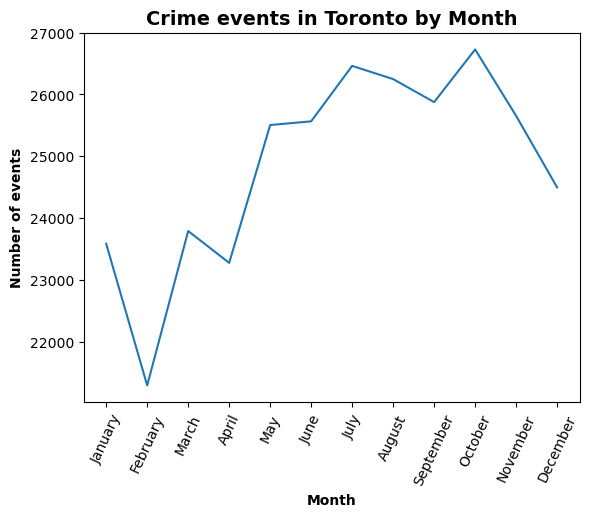

In [12]:
fig, ax = plt.subplots()

ax.plot(
    df_by_month['Month'],
    df_by_month['Number of events']
)

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto by Month',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(rotation=65)


plt.show()

In [13]:
# count by category and month
month_category_count = (df
    .groupby(['Month', 'Category'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

month_category_count.head()

,Month,Category,Number of events
0,January,Assault,12229
1,January,Auto Theft,3026
2,January,Break and Enter,5286
3,January,Robbery,2244
4,January,Theft Over,798


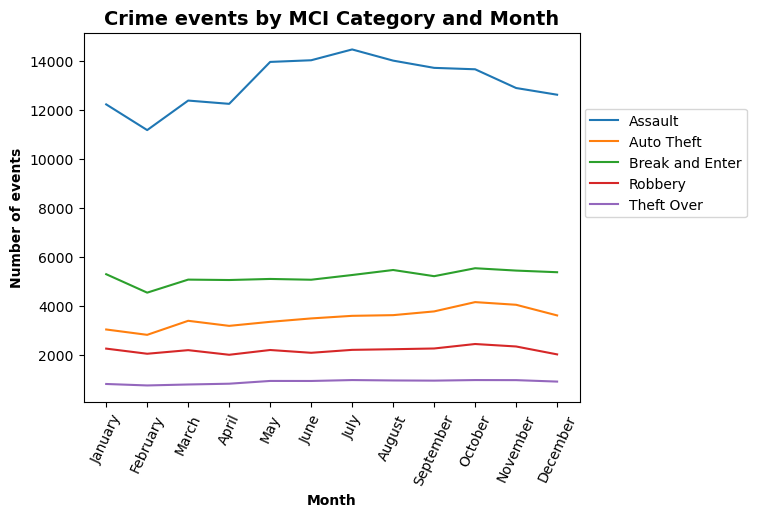

In [14]:
# Visualize

fig, ax = plt.subplots()

for mci_cat in mci_cats:
    this_data = month_category_count.loc[month_category_count['Category'] == mci_cat]
    # add this category to plot
    ax.plot(
        this_data['Month'],
        this_data['Number of events'],
        label=mci_cat,
        clip_on = False
    )

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by MCI Category and Month',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(rotation=65)
plt.legend(loc=(1.01, 0.5))

plt.show()

## By Year and Month

In [15]:
# count by year and month
year_month_count = (df
    .groupby(['Year', 'Month'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

year_month_count['Year Month'] = year_month_count.Month.astype('string') + ' ' + year_month_count.Year

year_month_count.head()

,Year,Month,Number of events,Year Month
0,2014,January,2410,January 2014
1,2014,February,2106,February 2014
2,2014,March,2330,March 2014
3,2014,April,2391,April 2014
4,2014,May,2714,May 2014


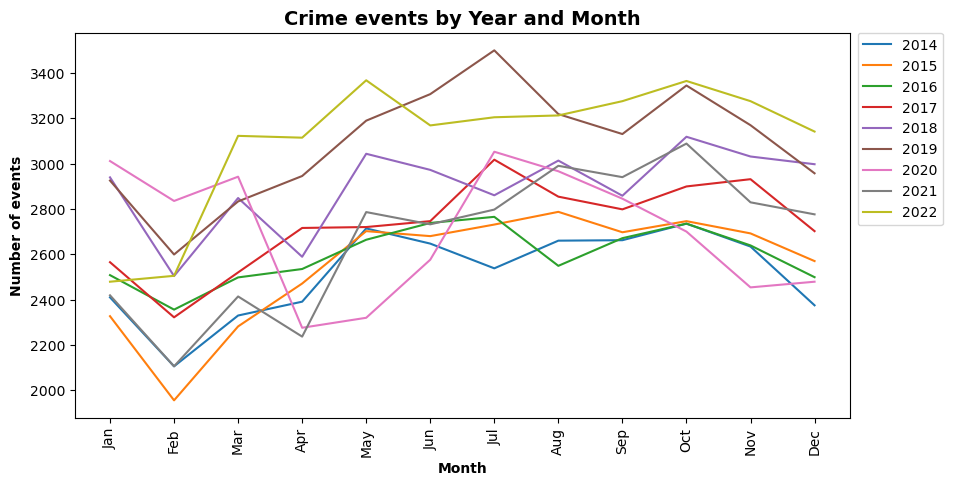

In [16]:
# Visualize

# List of years
years = list(year_month_count['Year'].unique())

fig, ax = plt.subplots(figsize=(10, 5))

for year in years:
    this_data = year_month_count.loc[year_month_count['Year'] == year]
    # add this category to plot
    ax.plot(
        this_data['Month'],
        this_data['Number of events'],
        label=year,
        clip_on = False
    )

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by Year and Month',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(
    ticks=np.arange(12),
    labels=[m[0:3] for m in year_month_count['Month'][0:12]],
    rotation=90
)

plt.legend(loc=(1.01, 0.5))

plt.show()

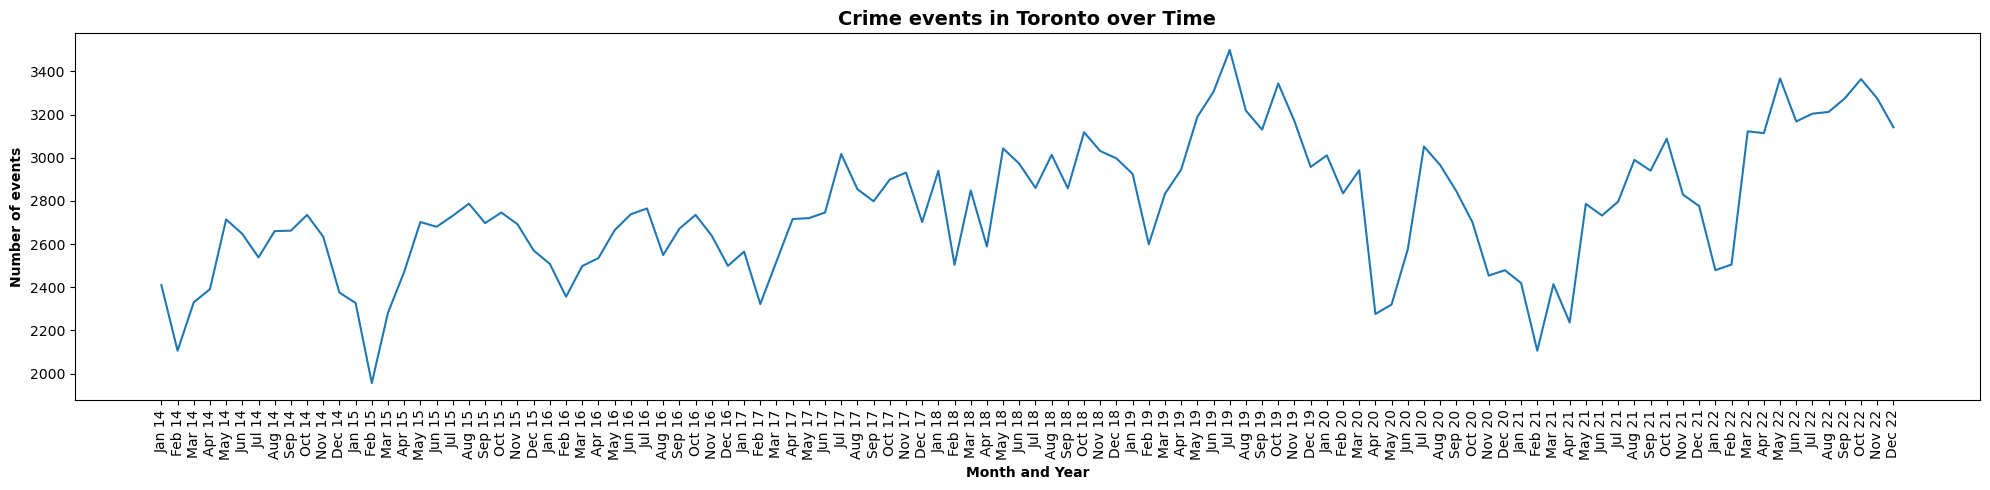

In [17]:
# Visualize

# List of years
years = list(year_month_count['Year'].unique())

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(
    year_month_count['Year Month'],
    year_month_count['Number of events']
)

# for year in years:
#     this_data = year_month_count.loc[year_month_count['Year'] == year]
#     # add this category to plot
#     ax.plot(
#         this_data['Year Month'],
#         this_data['Number of events'],
#         label=year,
#         # clip_on = False
#     )
# plt.legend(loc='upper left')

plt.xlabel('Month and Year', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events in Toronto over Time',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(
    ticks=np.arange(len(year_month_count['Year Month'])),
    labels=[m[0:3] + ' ' + y[2:4] for m, y in zip(year_month_count['Month'], year_month_count['Year'])],
    rotation=90
)

plt.tight_layout()


plt.show()

## By Day of the Week

In [18]:
df_by_dow = (df
    .groupby('Day of the Week', as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

df_by_dow

,Day of the Week,Number of events
0,Monday,41685
1,Tuesday,41093
2,Wednesday,42125
3,Thursday,42258
4,Friday,45135
5,Saturday,43902
6,Sunday,42274


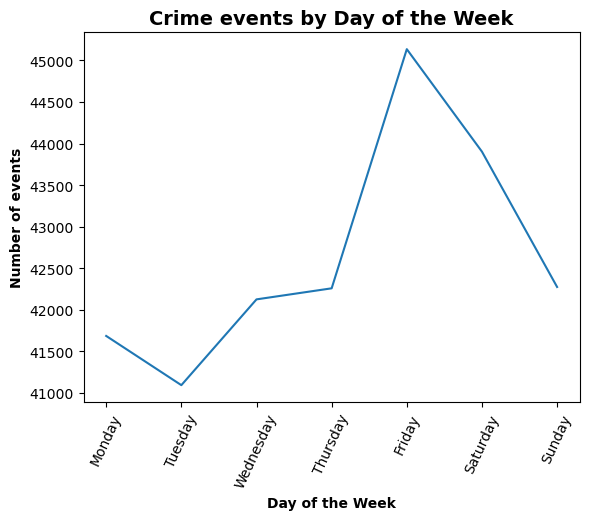

In [19]:
fig, ax = plt.subplots()

ax.plot(
    df_by_dow['Day of the Week'],
    df_by_dow['Number of events']
)

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by Day of the Week',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(rotation=65)


plt.show()

In [20]:
# count by category and dow
dow_category_count = (df
    .groupby(['Day of the Week', 'Category'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

dow_category_count.head()

,Day of the Week,Category,Number of events
0,Monday,Assault,21445
1,Monday,Auto Theft,5967
2,Monday,Break and Enter,9031
3,Monday,Robbery,3674
4,Monday,Theft Over,1568


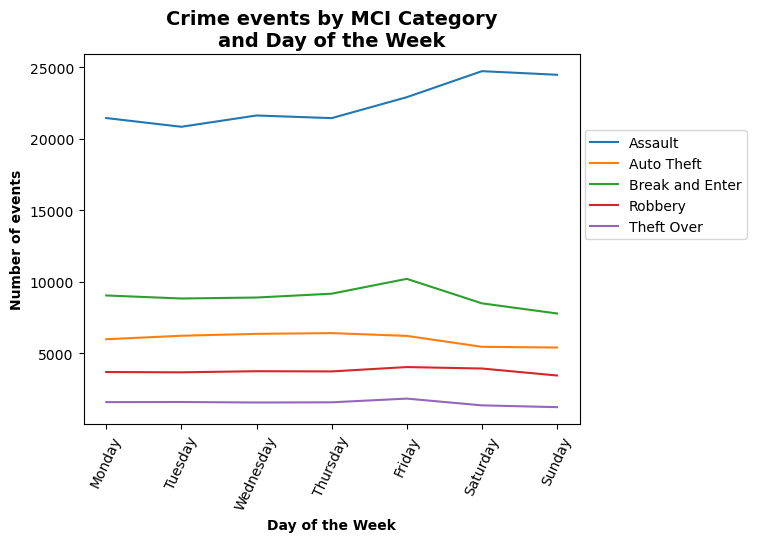

In [21]:
# Visualize

fig, ax = plt.subplots()

for mci_cat in mci_cats:
    this_data = dow_category_count.loc[month_category_count['Category'] == mci_cat]
    # add this category to plot
    ax.plot(
        this_data['Day of the Week'],
        this_data['Number of events'],
        label=mci_cat,
        clip_on = False
    )

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by MCI Category\nand Day of the Week',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(rotation=65)
plt.legend(loc=(1.01, 0.5))

plt.show()

In [22]:
# # count by year and dow
# year_dow_count = (df
#     .groupby(['Year', 'Day of the Week'], as_index=False)
#     .size()
#     .fillna(0)
#     .rename(columns={'size': 'Number of events'})
# )

# year_dow_count.head()

In [23]:
# # Visualize

# # List of years
# years = list(year_dow_count['Year'].unique())

# fig, ax = plt.subplots(figsize=(7, 5))

# for year in years:
#     this_data = year_dow_count.loc[year_dow_count['Year'] == year]
#     # add this category to plot
#     ax.plot(
#         this_data['Day of the Week'],
#         this_data['Number of events'],
#         label=year,
#         clip_on=False
#     )

# plt.xlabel('Day of the Week', fontdict={'weight': 700})
# plt.ylabel('Number of events', fontdict={'weight': 700})
# plt.title(
#     'Crime events by Year and Day of the Week',
#     fontdict={'weight': 700, 'size': 14}
# )

# plt.xticks(
#     ticks=np.arange(7),
#     labels=[m[0:3] for m in year_dow_count['Day of the Week'][0:7]],
#     rotation=90
# )

# plt.legend(loc=(1.01, 0.5))

# plt.show()


## By Hour of Day

In [24]:
df_by_hour = (df
    .dropna()
    .groupby('Hour', as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

df_by_hour

,Hour,Number of events
0,1.0,12175
1,2.0,11897
2,3.0,9894
3,4.0,7888
4,5.0,6176
5,6.0,5416
6,7.0,6293
7,8.0,8603
8,9.0,9945
9,10.0,10174


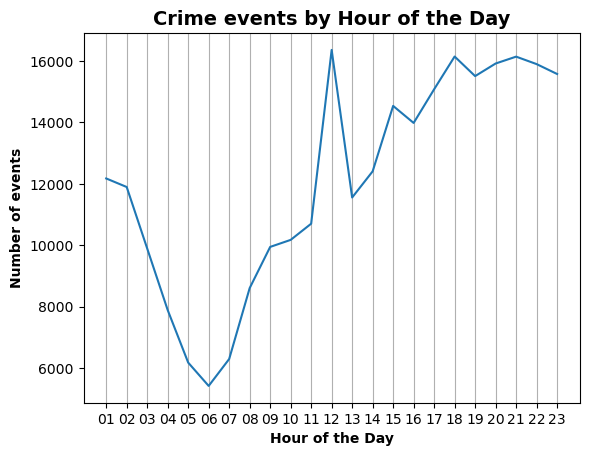

In [25]:
fig, ax = plt.subplots()

ax.plot(
    df_by_hour['Hour'],
    df_by_hour['Number of events']
)

plt.xlabel('Hour of the Day', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by Hour of the Day',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(
    ticks=np.arange(1, 24),
    labels=[str(n).zfill(2) for n in np.arange(1, 24)]
)
plt.grid(True, which='both', axis='x')

plt.show()

In [26]:
# count by category and hour
hour_category_count = (df
    .groupby(['Hour', 'Category'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Number of events'})
)

hour_category_count.head()

,Hour,Category,Number of events
0,1.0,Assault,6389
1,1.0,Auto Theft,1459
2,1.0,Break and Enter,2800
3,1.0,Robbery,1285
4,1.0,Theft Over,242


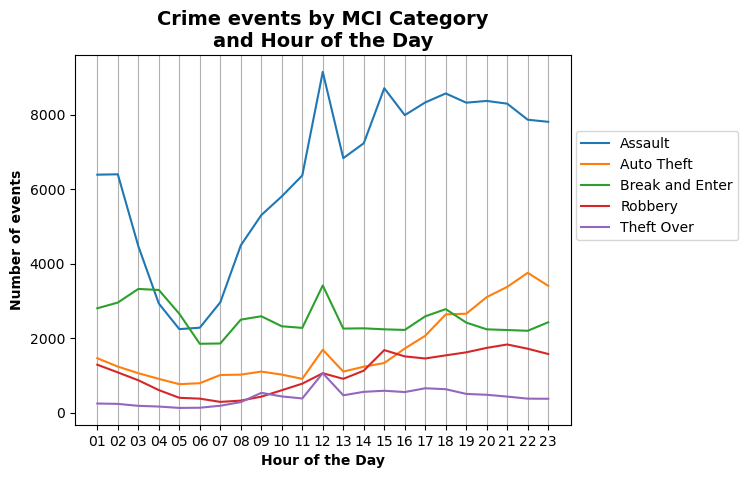

In [27]:
# Visualize

fig, ax = plt.subplots()

for mci_cat in mci_cats:
    this_data = hour_category_count.loc[hour_category_count['Category'] == mci_cat]
    # add this category to plot
    ax.plot(
        this_data['Hour'],
        this_data['Number of events'],
        label=mci_cat,
        clip_on = False
    )

plt.xlabel('Hour of the Day', fontdict={'weight': 700})
plt.ylabel('Number of events', fontdict={'weight': 700})
plt.title(
    'Crime events by MCI Category\nand Hour of the Day',
    fontdict={'weight': 700, 'size': 14}
    )

plt.xticks(
    ticks=np.arange(1,24),
    labels=[str(n).zfill(2) for n in np.arange(1,24)]
)
plt.legend(loc=(1.01, 0.5))
plt.grid(True, which='both', axis='x')


plt.show()